# Curve Fitting In Python

*Alan Paget | 2012-08-14*

A common feature of many immunoassays is that they have a **logistic dose-response curve** due to the underlying chemistry, and using ordinary linear or polynomial regression (no matter how easy in Excel) to establish a calibration curve is a bad idea. There are a few software packages for fitting non-linear calibration curves. They work by intelligently choosing calibration parameters that reduce the error in the fitted curve. Some of them have fancy features that reduce the incidence of bad fitting (either due to local minima/maxima or failure to converge). They often do the guess work on the initial parameters that you need to provide, so you don't have to provide them. 

Python (with scipy in tow) does a fine job of this task - providing you don't mind guessing the initial parameters, and tuning them if the resulting optimized curve-fit is poor. You can learn a lot doing it this way - but of course this code could be expanded to include provision of initial values, heuristics and mechanisms for handling poor fitting.

The R package drc - [**\[link\]**](https://cran.r-project.org/web/packages/drc/index.html) - does a great job of curve-fitting and is recommended if you are an R person.

## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

np.random.seed(42)

plt.style.use('seaborn-whitegrid')

### Custom Functions

In [2]:
def curve_4pl(x, A, B, C, D):
    """
        4PL logistic equation. Converts dose to response. 
        This is what we will optimize with scipy.optimize.curve_fit.
        x - Dose
        A - The lower asymptote. The minimum value that can be obtained.
        B - Hill's Slope. The Hill's slope refers to the steepness of the curve. It could either be positive or negative. 
        C - Inflection point. The concentration of analyte where y=D/2.
        D - The upper asymptote. The maximum value that can be obtained.
    """
    return ((A-D)/(1.0+((x/C)**B))) + D

def fit_4pl(y, A, B, C, D):
    """
        4PL logistic reverse equation. Converts a response to dose. 
        Use this to calculate the response from unknown samples.
        Parameters as per curve_4pl. Y is response.
    """
    return C * (((A - D) / (y - D)) - 1) ** (1/B)

## Simulation of Bioassay Data.

The statistician should work with colleagues at the bench to help optimise the placement of the calibrators. Doing this, eg. with equal calibrator placement on a **logartimic scale**, can yield a more reproducible fit. 

Equal non-log scale will be fine for the purposes of our simulated data.

You are encourage to have a play with the values in `cal_params` and re-run the cell to understand how they work together.

Let's generate a "true" dose-response relationship curve:


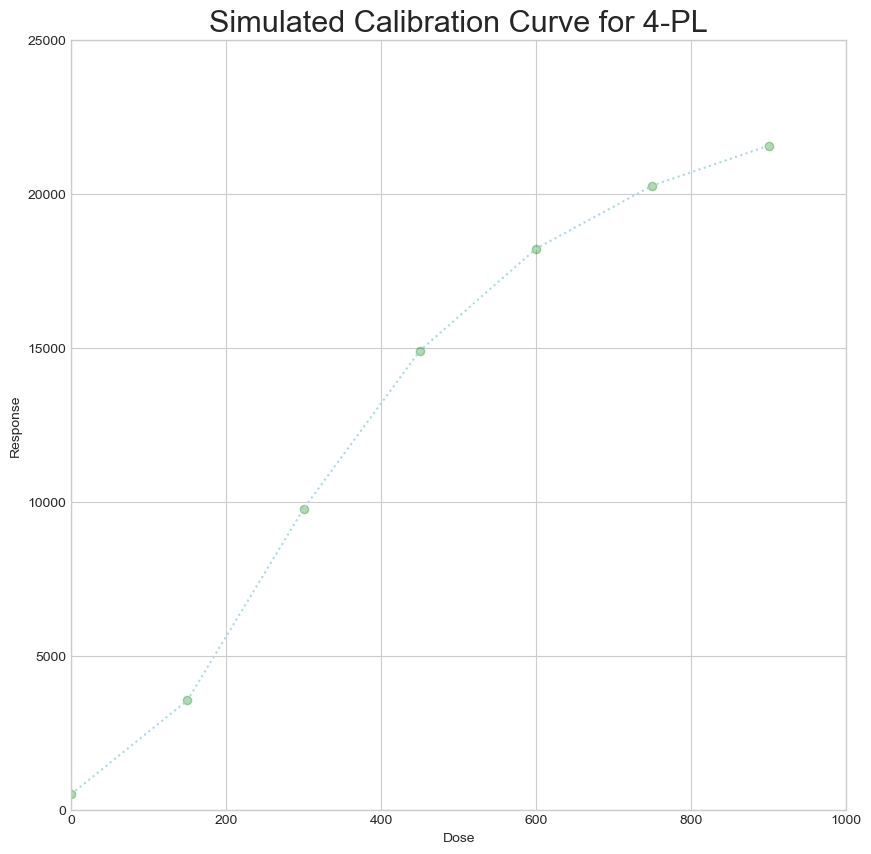

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]

cal_dose = np.linspace(0,900,7)
cal_params = {'a': 500, 'b': 2.1, 'c': 380, 'd': 25000}
cal_response = curve_4pl(cal_dose, cal_params['a'], cal_params['b'], cal_params['c'], cal_params['d'])

# Let's take a look at the underlying true dose response.
plt.plot(cal_dose, cal_response, linestyle = 'None', marker = 'o', alpha = 0.3, color = 'green')
plt.plot(cal_dose, cal_response, linestyle = ':', marker = 'None', color = 'lightblue')
plt.title('Simulated Calibration Curve for 4-PL', size = 22)
plt.xlim([0,1000])
plt.ylim([0,25000])
plt.xlabel('Dose')
plt.ylabel('Response')
plt.show()

Let's generate some simulated bioassay testing on the calibrators. 
The response for this assay has constant CV (coefficient of variation), rather than constant standard deviation. More antibody-analyte pairs with non-covalent binding means more variation in the response.

In [4]:
x_vals = np.array([])
y_vals = np.array([])

for rep in range(0,20):
    x_vals = np.append(x_vals, cal_dose)
    y_vals = np.append(y_vals, cal_response * np.random.normal(1, 0.1, len(cal_response)))

The resulting data looks like:

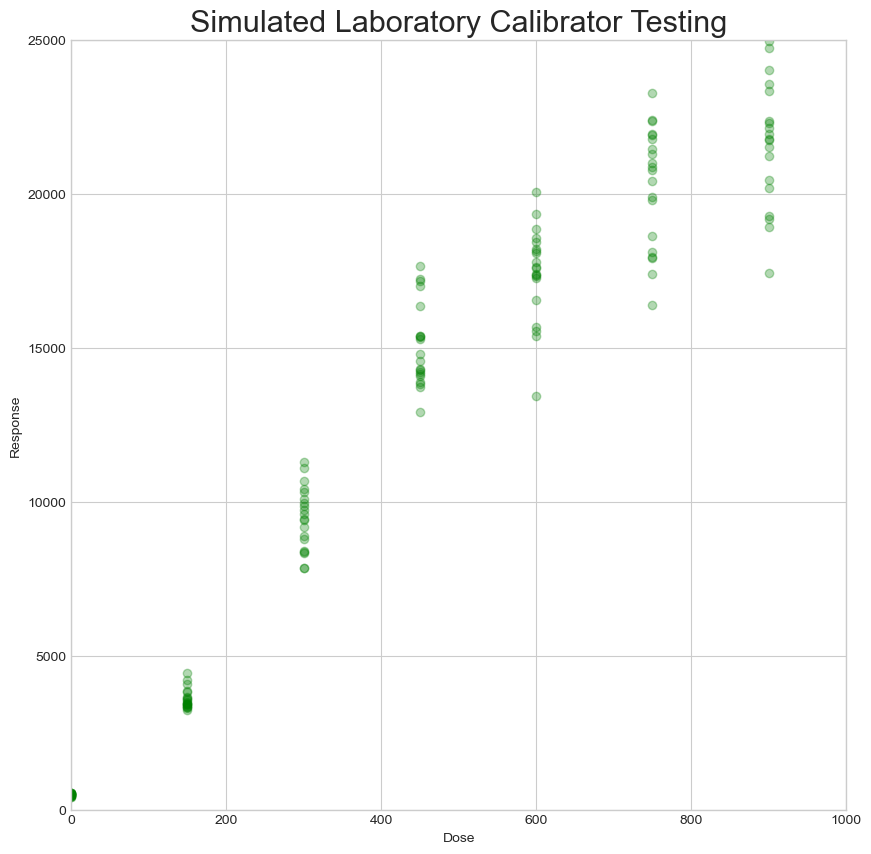

In [5]:
plt.plot(x_vals, y_vals, linestyle = 'None', marker = 'o', alpha = 0.3, color = 'green')
plt.title('Simulated Laboratory Calibrator Testing', size = 22)
plt.xlim([0,1000])
plt.ylim([0,25000])
plt.xlabel('Dose')
plt.ylabel('Response')
plt.show()

Ugh. This fake assay would perform hideously above a dose of about 500. A CV of 10% is not unheard of on quantitative ELISA plates, and these can often have quite marked non-linearity.

A lower imprecision assay, with a more linear response across the range is sought after by assay developers and clinicians.

Hopefully the medically important point for our pseudo-analyte isn't 500 or greater!

## Curve Fitting

### Fitting 4PL curves (Weighted and non-weighted).

In practice, we don't know the parameters for the curve fit. We need to work up an educated guess for these. Based on the description of the parameters for the 4-PL equation we can get quite far, and let the optimization routine improve them through iteration of and minimiziation of the errors.

*y* is response, *x* is dose:

$$y = d + \frac{a - d}{1 + (\frac{x}{c})^b}$$

| Parameter | Strategy |
| - | - |
| a - The lower asymptote. The minimum value that can be obtained. | The minimum response observed is a good guess. |
| b - Hill's Slope. The Hill's slope refers to the steepness of the curve. It could either be positive or negative. | Put in 1 and let the optimizer do the work. Use -1 when the assay has high response at low dose, and low response at high dose. | 
| c - Inflection point. The concentration of analyte where y=D/2. | Get your finger out and point at the x-value that's half-way between where the response flattens at top or bottom. |
| d - The upper asymptote. The maximum value that can be obtained. | The maximum response observed is a good guess.|


When fitting immunoassays with heteroscedastic variance, it's generally a good idea to provide weights so the optimizer doesn't give the top end of the curve too much priority. Depending on the analyte and assay, the patient might already be considered quite ill with a much lower concentration of analyte in their sample, and hence it's more important to get a nice fit further down the measuring range, where a clinician might rule in/out presence of the disease. Depending on the software used, the weights can be specified all sorts of different ways: 1/Y, 1/Y**2, 1/SD(Y) etc. 

**`Scipy.optimize.curve_fit` requires weights as SD(Y).**

Let's work out initial parameters given the above:

In [6]:
init_params = {'a': np.min(y_vals),
                      'b': 1, # let's just leave this at one and let the optimizer do the work. 
                      'c': 400, # It looks like a dose of about 400 gives a mid-response.
                      'd': np.max(y_vals)}

And here's where the magic happens. Check out the [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) documentation for more info.

In [7]:
# Add a really low number to avoid div by 0s.
x_vals = x_vals + 1e-20

# Unweighted fits.
fit_4pl_params = curve_fit(curve_4pl, x_vals, y_vals, [init_params['a'], init_params['b'], init_params['c'], init_params['d']])[0]

# We've got a reasonable number of reps (n = 20) so let's estimate standard deviation from the data.
# We need to provide a weight per rep of each dose-response pair, the below code does that:

weights = pd.DataFrame({'x': x_vals, 'y': y_vals}).groupby('x').std().reset_index()
weights = pd.DataFrame({'x': x_vals}).merge(weights, on = 'x')['y']
# Weighted fits.
fit_w4pl_params = curve_fit(curve_4pl, x_vals, y_vals, [init_params['a'], init_params['b'], init_params['c'], init_params['d']], sigma = weights)[0]

In the plots below, the dotted line represents the fitted curve for each method - both of these look reasonable at first glance:

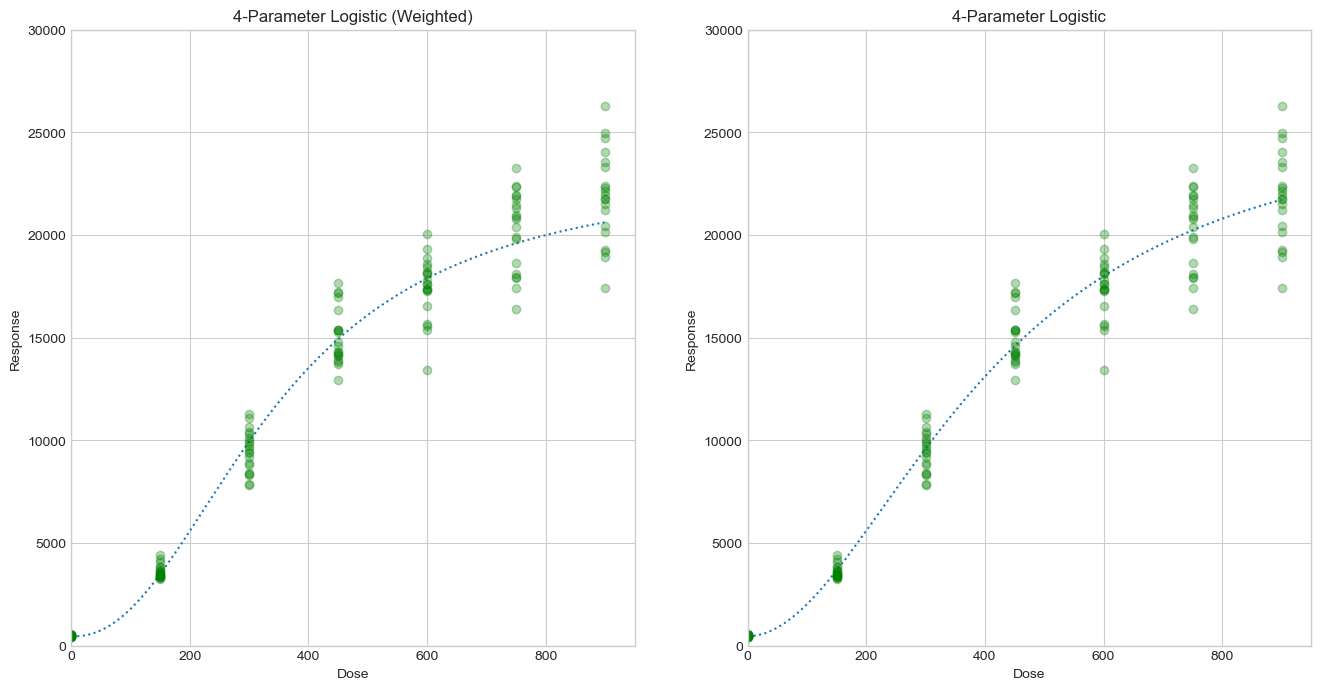

In [8]:
plt.rcParams['figure.figsize'] = [16, 8]

fig, ax = plt.subplots(1, 2)

ax[1].set_title("4-Parameter Logistic")
ax[1].plot(np.arange(1,900,1), 
             curve_4pl(np.arange(1,900,1), fit_4pl_params[0], fit_4pl_params[1], fit_4pl_params[2], fit_4pl_params[3]), 
             linestyle = ':', 
             marker = 'None')

ax[0].set_title("4-Parameter Logistic (Weighted)")
ax[0].plot(np.arange(1,900,1), 
             curve_4pl(np.arange(1,900,1), fit_w4pl_params[0], fit_w4pl_params[1], fit_w4pl_params[2], fit_w4pl_params[3]), 
             linestyle = ':', 
             marker = 'None')


for an_ax in ax.flat:
    an_ax.set(xlabel = 'Dose', ylabel = 'Response', xlim = [0, 950], ylim = [0, 30000])
    an_ax.plot(x_vals, y_vals, linestyle = 'None', marker = 'o', alpha = 0.3, color = 'green')
    
plt.show()

### Diagnostic Plotting for Proposed Curve Fits.
Based on what we know (we made the fake data after all) the **4PL-weighted** should be the right tool for the job. We have an assay with a variance profile that fans out as the dose increases, and a marked flattening-out of response at the very low and high doses.

Here is the back-fitted concentrations versus the doses for both curves:

Note this error through the notebook. This is due to the values being outside the range of the curve. It would be helpful to set these to output either < LOQ (limit of quantification) or > max range.


<ipython-input-2-31d972947313>:19: RuntimeWarning: invalid value encountered in power
  return C * (((A - D) / (y - D)) - 1) ** (1/B)


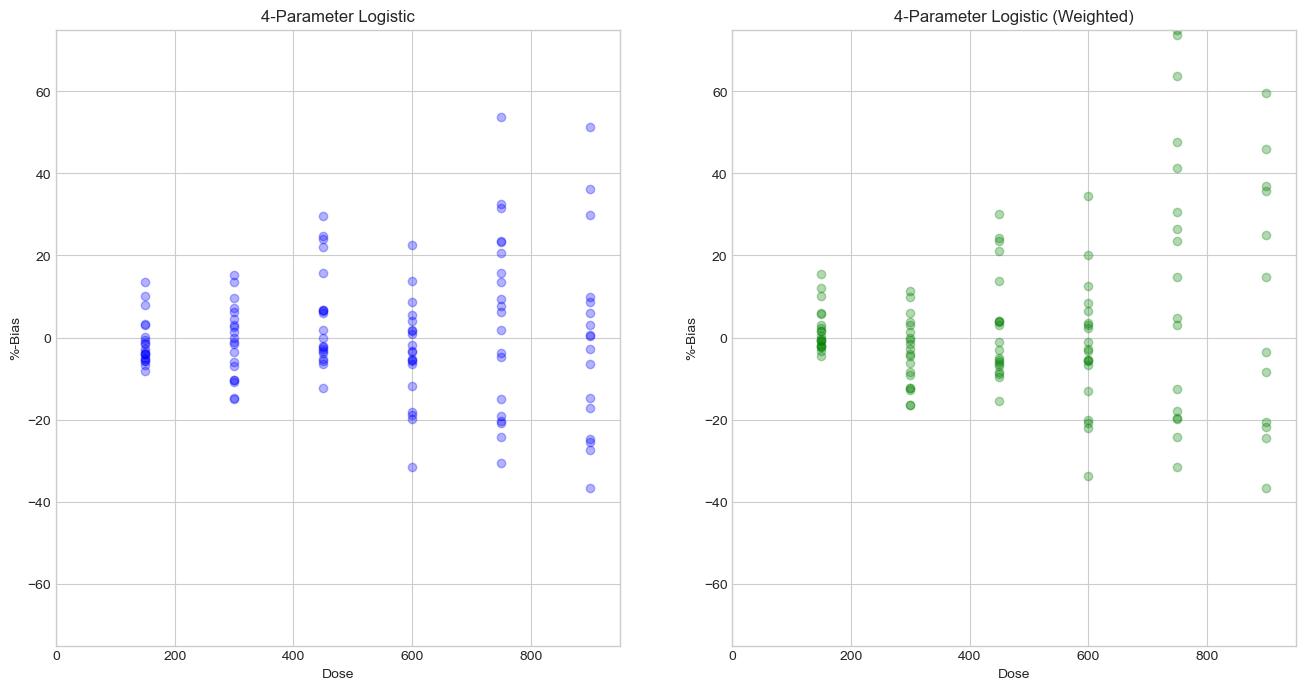

In [9]:
print("Note this error through the notebook. This is due to the values being outside the range of the curve. It would be helpful to set these to output either < LOQ (limit of quantification) or > max range.")

fit_data = pd.DataFrame({'x': x_vals, 
                         '4pl': fit_4pl(y_vals, fit_4pl_params[0], fit_4pl_params[1], fit_4pl_params[2], fit_4pl_params[3]),
                         'w4pl': fit_4pl(y_vals, fit_w4pl_params[0], fit_w4pl_params[1], fit_w4pl_params[2], fit_w4pl_params[3])})

fit_data['4pl'] = (fit_data['4pl'] - fit_data['x']) / fit_data['x'] * 100
fit_data['w4pl'] = (fit_data['w4pl'] - fit_data['x']) / fit_data['x'] * 100  

fig, ax = plt.subplots(1, 2)

ax[0].set_title("4-Parameter Logistic")
ax[0].plot('x', '4pl', data = fit_data, linestyle = 'None', marker = 'o', alpha = 0.3, color = 'blue')

ax[1].set_title("4-Parameter Logistic (Weighted)")
ax[1].plot('x', 'w4pl', data = fit_data, linestyle = 'None', marker = 'o', alpha = 0.3, color = 'green')

for an_ax in ax.flat:
    an_ax.set(xlabel = 'Dose', ylabel = '%-Bias', xlim = [0, 950], ylim = [-75, 75])

plt.show()

The weighted 4-PL looks to have higher bias, particularily at the higher end, when comparing the mean %-bias for each calibrator level:

In [10]:
average_bias = fit_data.groupby('x').mean()

print('Average %-Bias for Calibrators')
display(average_bias.truncate(1))

Average %-Bias for Calibrators


,4pl,w4pl
x,,
150.0,-1.019452,1.991814
300.0,-0.838796,-3.604220
450.0,4.963533,2.601768
600.0,-3.642569,-2.455980
750.0,5.086850,27.627056
900.0,9.491157,18.802058


## Validation

Let's see how our model works with unseen clinical samples. The CLSI EP-9A2 recommends collection of 120 samples, but *in-silico* clinical trials are cheap, so we'll do 300 of them in a clinical trial taking nanoseconds to complete :)

In [11]:
n_samples = 300

ref_vals = np.random.exponential(120, n_samples)
test_response = curve_4pl(ref_vals, cal_params['a'], cal_params['b'], cal_params['c'], cal_params['d']) * np.random.normal(1, 0.12, n_samples)
test_dose = fit_4pl(test_response, fit_4pl_params[0], fit_4pl_params[1], fit_4pl_params[2], fit_4pl_params[3])
test_dose_w = fit_4pl(test_response, fit_w4pl_params[0], fit_w4pl_params[1], fit_w4pl_params[2], fit_w4pl_params[3])

<ipython-input-2-31d972947313>:19: RuntimeWarning: invalid value encountered in power
  return C * (((A - D) / (y - D)) - 1) ** (1/B)


*\[Above\]* Again, that pesky error for values out of range...

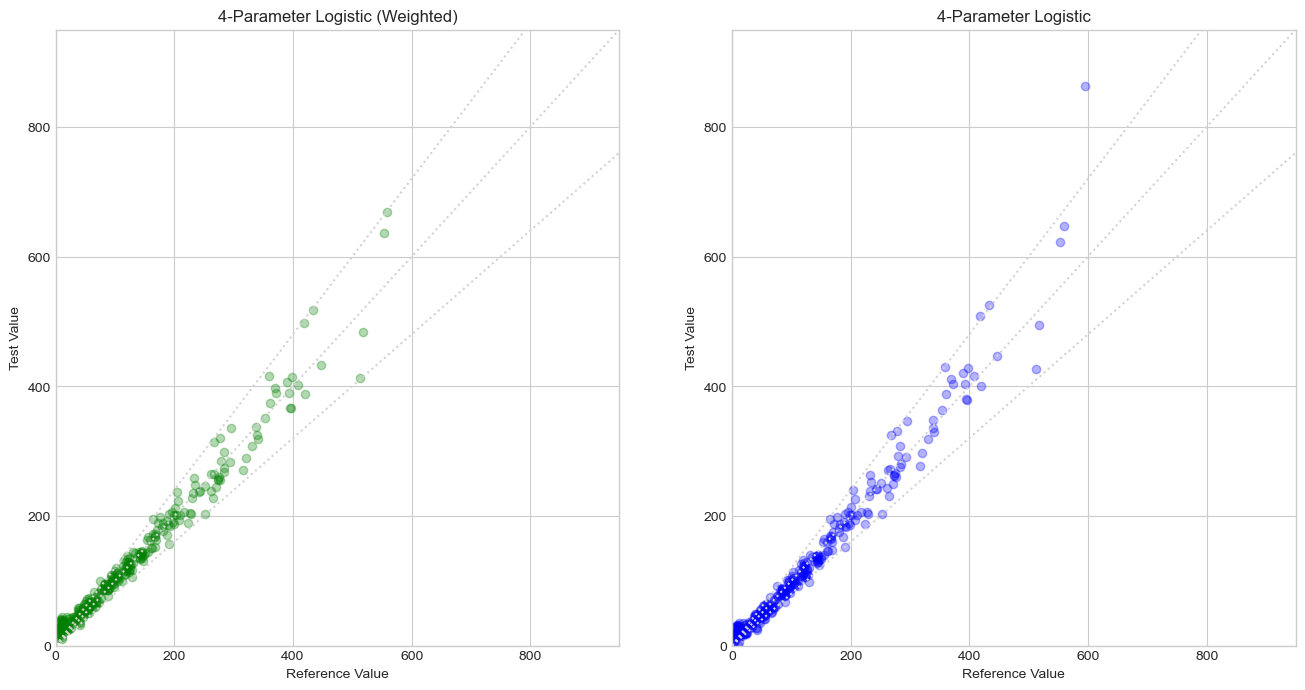

In [12]:
fig, ax = plt.subplots(1, 2)

ax[0].set_title("4-Parameter Logistic (Weighted)")
ax[0].plot(ref_vals, test_dose_w, linestyle = 'None', marker = 'o', alpha = 0.3, color = 'green')

ax[1].set_title("4-Parameter Logistic")
ax[1].plot(ref_vals, test_dose, linestyle = 'None', marker = 'o', alpha = 0.3, color = 'blue')

for an_ax in ax.flat:
    an_ax.set(xlabel = 'Reference Value', ylabel = 'Test Value', xlim = [0, 950], ylim = [0, 950])
    an_ax.axline([0,0], [950,950], linestyle = ':', marker = 'None', color = 'lightgrey')
    an_ax.axline([0,0], slope = 1.2, linestyle = ':', marker = 'None', color = 'lightgrey')
    an_ax.axline([0,0], slope = 0.8, linestyle = ':', marker = 'None', color = 'lightgrey')

plt.show()

Looks like a decent fit, with a good chunk of the data in the +/- 20% error lines. The fitted values still looks a little non-linear - particularily at the low end. Let's plot the relative bias ...

In [13]:
rel_bias = pd.DataFrame({"ref": ref_vals, "test_dose": test_dose, "w_test_dose": test_dose_w})

# Get rid of out of range values:
rel_bias = rel_bias.dropna()
rel_bias['rel'] = (rel_bias['test_dose'] - rel_bias['ref']) / rel_bias['ref'] * 100
rel_bias['w_rel'] = (rel_bias['w_test_dose'] - rel_bias['ref']) / rel_bias['ref'] * 100

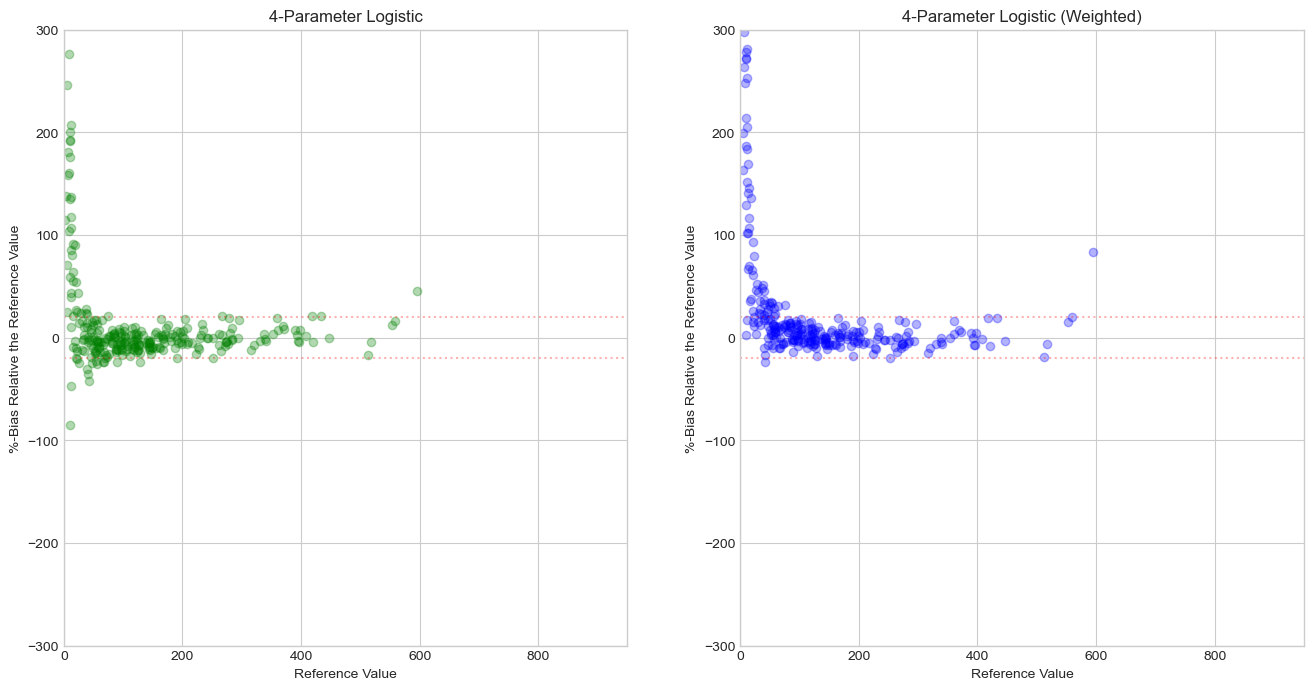

In [14]:
fig, ax = plt.subplots(1, 2)

ax[0].set_title("4-Parameter Logistic")
ax[0].plot('ref', 'rel', data = rel_bias, linestyle = 'None', marker = 'o', alpha = 0.3, color = 'green')

ax[1].set_title("4-Parameter Logistic (Weighted)")
ax[1].plot('ref', 'w_rel', data = rel_bias, linestyle = 'None', marker = 'o', alpha = 0.3, color = 'blue')

for an_ax in ax.flat:
    an_ax.set(xlabel = 'Reference Value', ylabel = '%-Bias Relative the Reference Value', xlim = [0, 950], ylim = [-300, 300])
    an_ax.axline([0,20], [950,20], linestyle = ':', marker = 'None', alpha = 0.3, color = 'red')
    an_ax.axline([0,-20], [950,-20], linestyle = ':', marker = 'None', alpha = 0.3, color = 'red')
plt.show()

This sort of bias plot is called a [Bland-Altman plot](https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot). A quantitative look at the mean %-bias in a few bins of clinical interest...

In [15]:
rel_bias['bins'] = pd.cut(rel_bias['ref'], bins = [0,10,50,100,200,900])
rel_bias.pivot_table(index = 'bins', values =['rel','w_rel'], aggfunc = ['count','std', 'mean'])

count               std                    mean            
             rel w_rel         rel       w_rel         rel       w_rel
bins                                                                  
(0, 10]       22    22  582.044983  752.551934  502.517725  762.156696
(10, 50]      61    61   63.883578   79.239159   31.117993   70.565032
(50, 100]     64    64   10.773965   10.982982   -5.562397    6.780019
(100, 200]    81    81    7.839538    7.365135   -3.687170    0.348480
(200, 900]    61    61   11.283777   14.371430    2.228218    0.842429

Quite a bit of bias at the low end observed here.

## Summary

In summary:

* Scipy provides useful tools for calibration curve-fitting.
* Looking at the increasing bias for samples with concentrations less than about 20, there's an under-fitting issue going on at the low-end. Perhaps optimising our calibrator placement to deal with this (and/or adding more calibrators) would be beneficial. 
* Estimation of %-bias of the fitted values versus reference concentration is a handy diagnostic measure.
* Both the weighted and unweighted 4PL perform reasonably well, but the weighted 4-PL performs worse at the low end. This could be due to mis-estimation of the weights - this requires a lot of replicates to do well. Perhaps substituting our empirical estimates of SD for another measure, e.g. 0.1 * mean response, would benefit the curve-fit.